## Setup

In [61]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [63]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [64]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [65]:
%%R 

census_api_key(Sys.getenv("29f693f36ff7038b0f4b17aa4c6c372ca3da30af")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [67]:
%%R
library(tidycensus)
library(dplyr)

# Load ACS 5-year 2023 variable list
acs_vars <- load_variables(2023, "acs5", cache = TRUE)

# Filter for B13016 variables
filtered_vars <- acs_vars %>%
  filter(grepl("^B13016", name))

# Show the first 20 rows
head(filtered_vars, 20)

# Show the last 20 rows
tail(filtered_vars, 20)

# A tibble: 17 × 4
   name       label                                                                                       concept                                                           geography
   <chr>      <chr>                                                                                       <chr>                                                             <chr>    
 1 B13016_001 Estimate!!Total:                                                                            Women 15 to 50 Years Who Had a Birth in the Past 12 Months by Age <NA>     
 2 B13016_002 Estimate!!Total:!!Women who had a birth in the past 12 months:                              Women 15 to 50 Years Who Had a Birth in the Past 12 Months by Age <NA>     
 3 B13016_003 Estimate!!Total:!!Women who had a birth in the past 12 months:!!15 to 19 years old          Women 15 to 50 Years Who Had a Birth in the Past 12 Months by Age <NA>     
 4 B13016_004 Estimate!!Total:!!Women who had a birth in the past 12 mo

In [68]:
%%R

nyc_census_data <- get_acs(
  geography = "tract",
  state = "NY",
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    population = "B01003_001",
    birth = "B13016_003"
  ),
  year = 2023,
  survey = "acs5",
  geometry = TRUE
)

nyc_census_data



Simple feature collection with 4654 features and 5 fields (with 6 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME   variable estimate moe                       geometry
1  36005023502 Census Tract 235.02; Bronx County; New York population     4284 896 MULTIPOLYGON (((-73.906 40....
2  36005023502 Census Tract 235.02; Bronx County; New York      birth        0  13 MULTIPOLYGON (((-73.906 40....
3  36005013500    Census Tract 135; Bronx County; New York population     3295 699 MULTIPOLYGON (((-73.90508 4...
4  36005013500    Census Tract 135; Bronx County; New York      birth        0  13 MULTIPOLYGON (((-73.90508 4...
5  36005009200     Census Tract 92; Bronx County; New York population     5675 696 MULTIPOLYGON (((-73.85773 4...
6  36005009200     Census Tract 92; Bronx County; New York      birth 

Getting data from the 2019-2023 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [69]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 6 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 7
   GEOID       NAME                                                                                                                 geometry population_estimate birth_estimate population_moe birth_moe
   <chr>       <chr>                                                                                                      <MULTIPOLYGON [°]>               <dbl>          <dbl>          <dbl>     <dbl>
 1 36005023502 Census Tract 235.02; Bronx County; New York (((-73.906 40.84939, -73.90562 40.84992, -73.90513 40.85053, -73.90467 40.8511, …                4284              0            896        13
 2 36005013500 Census Tract 135; Bronx County; New York    (((-73.90508 40.82711, -73.90385 40.82819, -73.90346 40.82853, -73.90228 40.8296…        

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [70]:
%%R 

# your code here. refer to example notebooks for help
nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ";") %>% map_chr(2) %>% str_trim()
    )

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


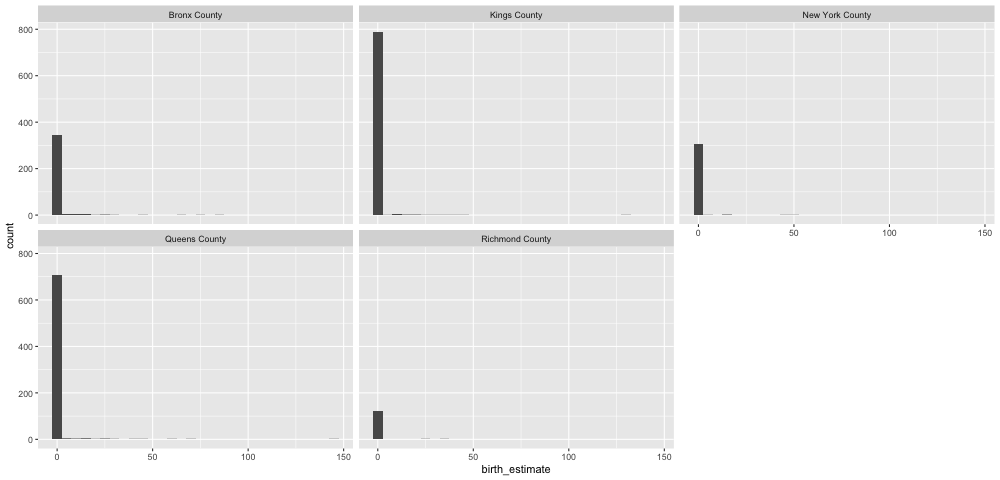

In [71]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=birth_estimate) +
    geom_histogram() +
    facet_wrap(~borough)

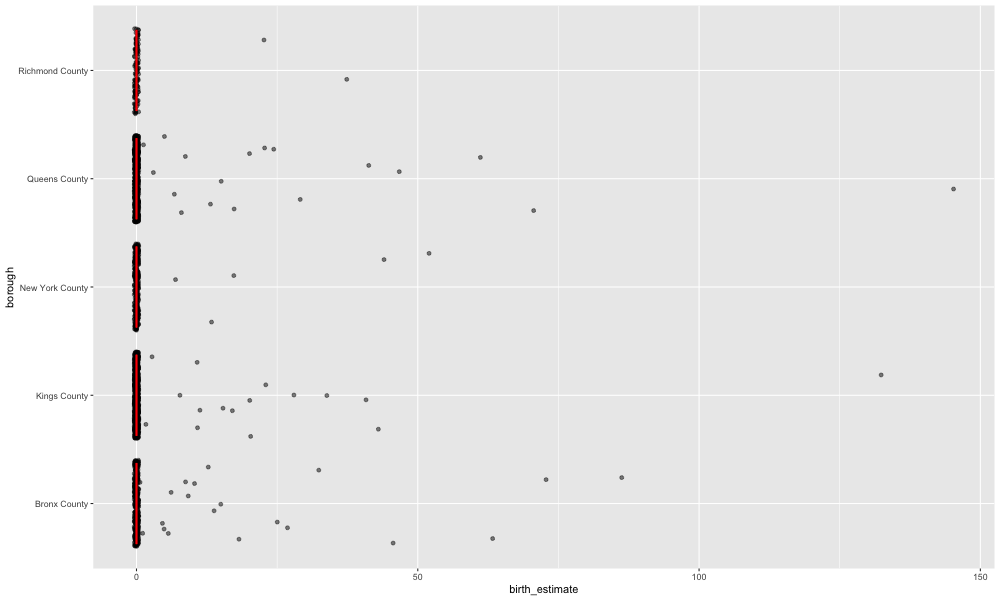

In [72]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=birth_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 
# your code here. refer to example notebooks for help


### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In [73]:
%%R 

library(tigris)

# remove water from the shapefiles
# https://walker-data.com/tidycensus/articles/spatial-data.html
nyc_census_data <- nyc_census_data %>% 
    erase_water()

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


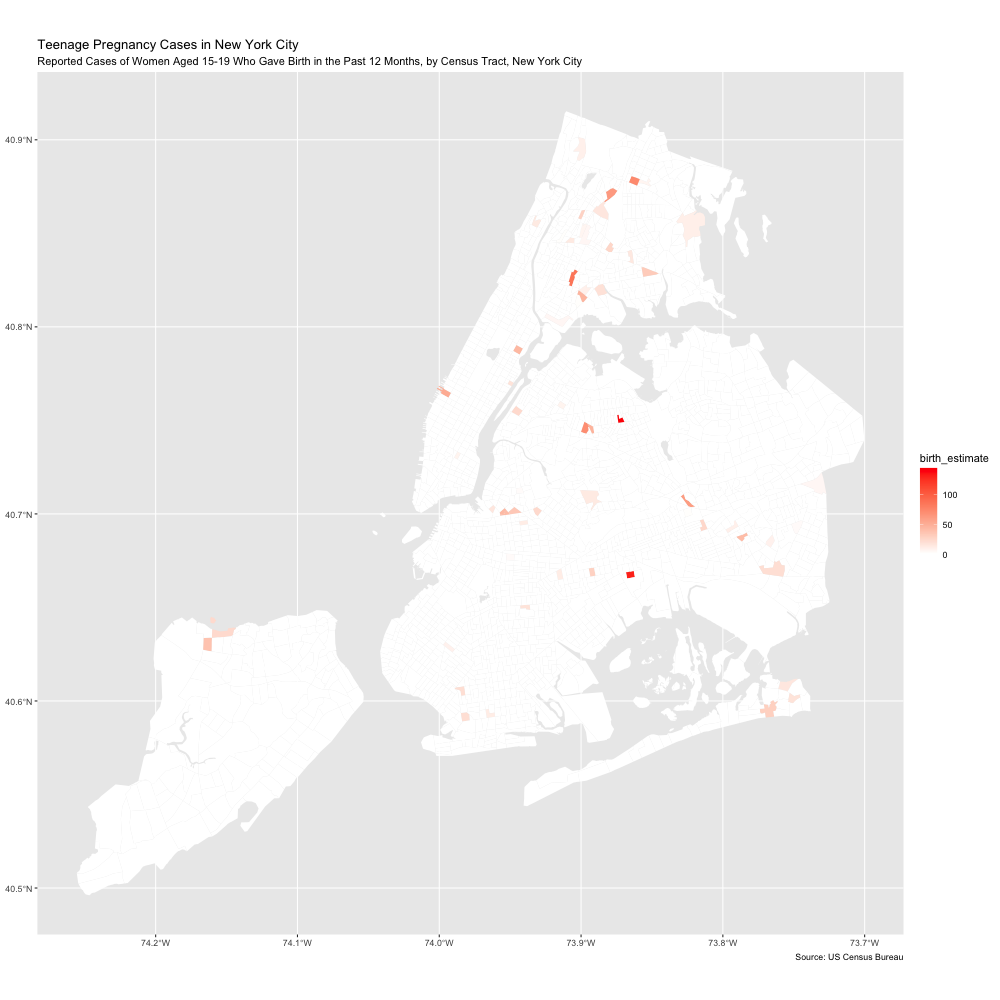

In [80]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = birth_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "Teenage Pregnancy Cases in New York City",
    subtitle = "Reported Cases of Women Aged 15-19 Who Gave Birth in the Past 12 Months, by Census Tract, New York City",
    caption = "Source: US Census Bureau"
  )

#ggsave("nyc_teen_pregnancy.png", width=10, height=10, dpi=300)

In [77]:
%%R
nyc_census_data %>%
    filter(birth_estimate > 50)

Simple feature collection with 8 features and 7 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -74.00171 ymin: 40.66547 xmax: -73.81938 ymax: 40.88054
Geodetic CRS:  NAD83
# A tibble: 8 × 8
  GEOID       NAME                                           population_estimate birth_estimate population_moe birth_moe borough                                                                geometry
* <chr>       <chr>                                                        <dbl>          <dbl>          <dbl>     <dbl> <chr>                                                             <POLYGON [°]>
1 36081013800 Census Tract 138; Queens County; New York                     3923             61            803        98 Queens County   ((-73.82814 40.70796, -73.82444 40.70406, -73.82344 40.7038, -…
2 36081026300 Census Tract 263; Queens County; New York                     4953             71            758       107 Queens County   ((-73.90003 40.74376, -73.89754 40.74312, -73.89